In [ ]:
import numpy as np
import pandas as pd
from openai import OpenAI
from datetime import datetime
from pathlib import Path
from typing import List
import re
from dotenv import load_dotenv
from pydantic import BaseModel
import json
import matplotlib.pyplot as plt
import textwrap

## Helper Functions

In [2]:
def save_df_to_csv(samples_df: pd.DataFrame, name: str = 'samples', directory: str = './data/'):
    timestamp_str = datetime.now().strftime("%Y%m%d%H%M%S")
    samples_df.to_csv(f"{directory}{name}_{timestamp_str}.csv")

In [3]:
def list_files(directory: str) -> List[str]:
    """Return all file names (not directories) in the given directory."""
    path = Path(directory).expanduser()
    return [p.name for p in path.iterdir() if p.is_file()]

In [4]:
def get_last_saved_timestamp(directory: str = './data/'):
    filenames = list_files(directory)
    matches = [ re.search(r'.*?(\d{14})\.csv$', fn) for fn in filenames ]
    timestamps = [ int(m.group(1)) for m in matches if m is not None ]
    return str(max(timestamps))

In [5]:
def load_df(timestamp: str, name: str = 'samples', directory: str = './data/') -> pd.DataFrame:
    return pd.read_csv(f"{directory}{name}_{timestamp}.csv", index_col=0)

In [6]:
def load_latest_df(name: str = 'samples', directory: str = './data/') -> pd.DataFrame:
    timestamp = get_last_saved_timestamp(directory=directory)
    return load_df(timestamp=timestamp, name=name, directory=directory)

## Generate Synthetic Data

In [7]:
# read in env vars from the .env file
load_dotenv(override=True)

# PROMPT_ID_SYNTH_GEN = os.environ['PROMPT_ID_SYNTH_GEN']
# PROMPT_ID_SUFFIX_LIST = ['SMALL', 'MEDIUM', 'LARGE']
# ALL_MODELS_LIST = ['gpt-5-nano', 'gpt-5-mini', 'gpt-5.1']
 
SYNTH_GEN_MODEL = 'gpt-4.1-2025-04-14'
ALL_MODELS_LIST = ['gpt-4.1-2025-04-14', 'gpt-4.1-mini-2025-04-14', 'gpt-4.1-nano-2025-04-14']

# connect and get an OpenAI client
client = OpenAI()

In [8]:
def strip_trailing_date(text: str) -> str:
    return re.sub(r"-\d{4}-\d{2}-\d{2}$", "", text)

In [9]:
class BioSnippet(BaseModel):
    text_snippet: str
    source: str
    is_match: bool

In [10]:
class UserWithLabeledSnippets(BaseModel):
    first_name: str
    last_name: str
    city: str
    state: str
    birth_year: int
    snippets: list[BioSnippet]

In [11]:
class ListOfUsersWithLabeledSnippets(BaseModel):
    users: list[UserWithLabeledSnippets]

In [ ]:
def generate_synthetic_samples(model, n_people=10, temperature=0.7) -> pd.DataFrame:
    resp = client.responses.parse(
        model=model,
        input=[
            {
                "role": "user",
                "content": f"""
                    Generate {n_people} example fictional people. 
                    - Each person should have 5 to 10 snippets. 
                    - Each snippet should represent a brief bio of the fictional person found via googling. e.g. a whitepages.com listing, an instagram bio, a reddit post, etc.
                    - Each snippet should either actually match the person, and hence have a label of is_match=True, or it should be a close, but not actual, match, and have is_match=False.
                    - 
                    - About half of the snippets per person should be true matches, and half should be false.
                    - Each snippet should have a source (e.g. whitepages, reddit, instagram)
                """,
            },
        ],
        text_format=ListOfUsersWithLabeledSnippets,
        temperature=temperature,
    )   
    users_list = json.loads(resp.output_text)['users']

    samples_df = pd.DataFrame(columns=['First Name', 'Last Name', 'City', 'State', 'Birth Year', 'Text Snippet', 'Source', 'Is Match'])
    for user in users_list:
        for snippet in user['snippets']:
            new_row = {
                "First Name": user['first_name'],
                "Last Name": user['last_name'],
                "City": user['city'],
                "State": user['state'],
                "Birth Year": user['birth_year'],
                "Text Snippet": snippet['text_snippet'],
                "Source": snippet['source'],
                "Is Match": snippet['is_match'],
            }
            samples_df = pd.concat([samples_df, pd.DataFrame([new_row])], ignore_index=True)

    save_df_to_csv(samples_df)

    return samples_df


In [13]:
#### This is commented out because it makes a lot of calls to ChatGPT. Uncomment to generate new data.
samples_df = generate_synthetic_samples(SYNTH_GEN_MODEL, n_people=10)

In [17]:
samples_df.head()

,First Name,Last Name,City,State,Birth Year,Text Snippet,Source,Is Match
0,Jessica,Morrison,Portland,Oregon,1991,"Jessica Morrison, Portland OR, works as a grap...",LinkedIn,True
1,Jessica,Morrison,Portland,Oregon,1991,"Jessica Morrison, age 32, Portland — whitepage...",whitepages.com,True
2,Jessica,Morrison,Portland,Oregon,1991,"@jessica.morrison91 - Coffee lover, dog mom, a...",Instagram,True
3,Jessica,Morrison,Portland,Oregon,1991,"Jessica Morrison, Portland, member of the Oreg...",Facebook,True
4,Jessica,Morrison,Portland,Oregon,1991,"Jessica Morrison, Seattle, works as a nurse at...",LinkedIn,False


## Use Different Models to Score Synthetic Data

In [18]:
class MatchScoreResponse(BaseModel):
    match_prob: float

In [19]:
class MatchScoreResponseWithReason(MatchScoreResponse):
    reason: str

In [20]:
def construct_match_prob_prompt(first_name, last_name, city, state, birth_year, snippet, source, include_reason=False):
    prompt = f"""
        Here is the profile of a person. (The current year is 2025). 
        - First Name: {first_name}
        - Last Name: {last_name}
        - City: {city}
        - State: {state}
        - Birth Year: {birth_year}
        Here is a snippet found online via googling that person: "{snippet}"

        It is from {source}.

        Please output the probability (a number from 0 to 1 rounded to two decimal places) that the snippet is 
        referring to that specific person. 1 means you are absolutely sure that it is a match, and 0 means that you
        are absolutely sure it is not.
    """

    if include_reason:
        prompt += "\n\nInclude your your reasoning for the score you gave, in one or two sentences."

    return prompt


In [21]:
def get_match_prob(row, model, include_reason=False, temperature=0.0):
    first_name = row['First Name']
    last_name = row['Last Name']
    city = row['City']
    state = row['State']
    birth_year = row['Birth Year']
    snippet = row['Text Snippet']
    source = row['Source']

    input_message = construct_match_prob_prompt(first_name, last_name, city, state, birth_year, snippet, source, include_reason)

    text_format = MatchScoreResponseWithReason if include_reason else MatchScoreResponse

    resp = client.responses.parse(
        model=model,
        input=[
            {
                "role": "user",
                "content": input_message
            },
        ],
        text_format=text_format,
        temperature=temperature,
    )   

    if include_reason:
        return (float(json.loads(resp.output_text)['match_prob']), json.loads(resp.output_text)['reason'])
    else:
        return (float(json.loads(resp.output_text)['match_prob']), None)

In [23]:
# get_match_prob(samples_df.iloc[0], "gpt-4.1-2025-04-14")

In [25]:
def get_all_match_probs(df, model, include_reason=False, temperature=0.0):
    match_probs_list = []
    reasons_list = []
    for _, row in df.iterrows():
        match_prob, reason = get_match_prob(row, model, temperature)
        match_probs_list.append(match_prob)
        if include_reason:
            reasons_list.append(reason)
    
    model_alias = strip_trailing_date(model)

    df[f"Match Prob {model_alias}"] = pd.Series(match_probs_list, index=df.index)
    if include_reason:
        df[f"Reason {model_alias}"] = pd.Series(reasons_list, index=df.index)

In [26]:
def run_all_prompt_scorers(df, include_reason=False, temperature=0.0):
    for model in ALL_MODELS_LIST:
        get_all_match_probs(df, model=model, include_reason=include_reason, temperature=temperature)

In [27]:
#### This is commented out because it makes a lot of calls to ChatGPT. Uncomment to re-score the synthetic data.
run_all_prompt_scorers(samples_df)

### Use this to instead load the latest saved data
# samples_df = load_latest_df()

## Analyze the Results

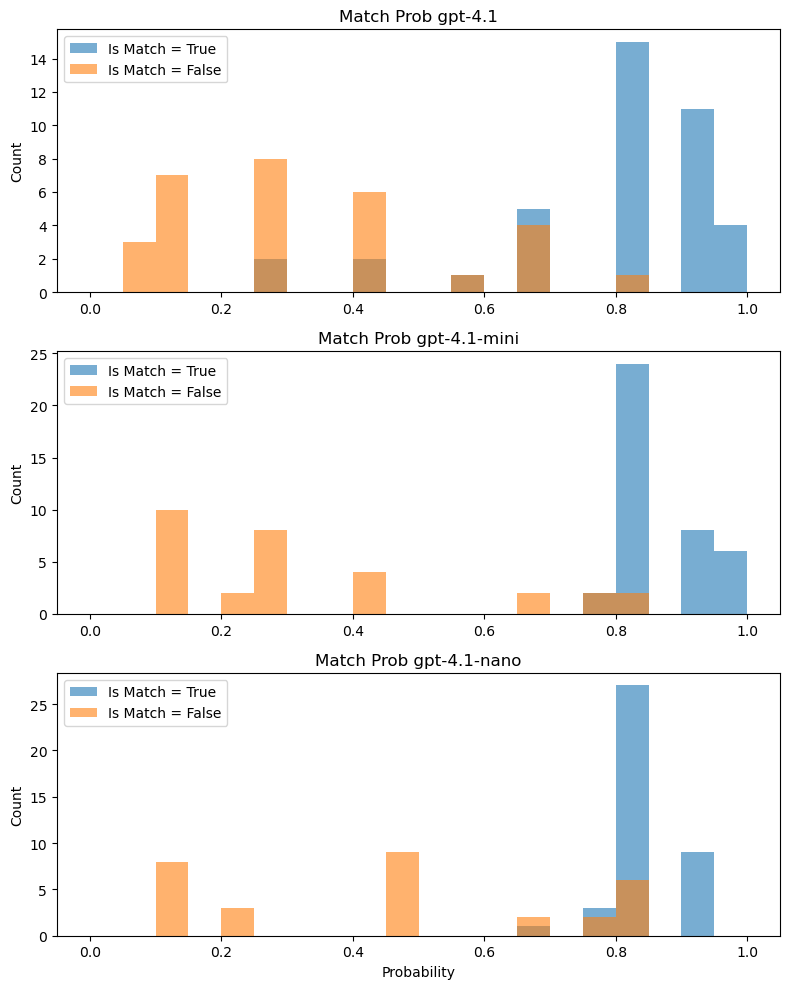

In [28]:
cols = [ f"Match Prob {strip_trailing_date(model)}" for model in ALL_MODELS_LIST ]
df_true = samples_df[samples_df["Is Match"] == True]
df_false = samples_df[samples_df["Is Match"] == False]

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 10), sharex=False)
for ax, col in zip(axes, cols):
    bins = np.linspace(0.0, 1.0, 21)  # 20 bins
    ax.hist(df_true.loc[df_true[col] >= 0.0, col], bins=bins, alpha=0.6, label="Is Match = True", color="tab:blue")
    ax.hist(df_false.loc[df_false[col] >= 0.0, col], bins=bins, alpha=0.6, label="Is Match = False", color="tab:orange")
    ax.set_title(col)
    ax.set_ylabel("Count")
    ax.legend()

axes[-1].set_xlabel("Probability")
fig.tight_layout()
plt.show()

In [ ]:
for model in ALL_MODELS_LIST:
    model_alias = strip_trailing_date(model)
    col = f"Match Prob {model_alias}"
    probs_true = samples_df.loc[samples_df['Is Match'], col]
    probs_false = samples_df.loc[~(samples_df['Is Match'].astype(bool)), col]
    
    print(f"Using {model_alias} Model:")
    print(f"True Matches:\t{probs_true.mean():.2f}")
    print(f"False Matches:\t{probs_false.mean():.2f}\n")


In [29]:
def get_accuracy(df, model, thresh: float = 0.5) -> float:
    model_alias = strip_trailing_date(model)
    predictions = df[f"Match Prob {model_alias}"] > thresh
    print(f"{model_alias}: ")
    print(f"Total observations:\t{len(df)}")
    print(f"True match count:\t{df['Is Match'].sum()}")
    print(f"Predicted true matches:\t{predictions.sum()}")
    print(f"Correct predcitions:\t{(predictions == df['Is Match']).sum()}\n")

In [30]:
_ = [ get_accuracy(samples_df, model) for model in ALL_MODELS_LIST ]

gpt-4.1: 
Total observations:	70
True match count:	40
Predicted true matches:	42
Correct predcitions:	60

gpt-4.1-mini: 
Total observations:	70
True match count:	40
Predicted true matches:	46
Correct predcitions:	64

gpt-4.1-nano: 
Total observations:	70
True match count:	40
Predicted true matches:	50
Correct predcitions:	60



In [31]:
def bce_loss(df, model) -> float:
    model_alias = strip_trailing_date(model)
    epsilon = 1e-6
    y = df['Is Match'].astype(float)
    probs = np.clip(df[f"Match Prob {model_alias}"], epsilon, 1-epsilon)
    loss = (y * np.log(probs) + (1 - y) * np.log(1 - probs)).sum()
    return loss

In [32]:
def calc_and_print_bce_loss(df, model):
    loss = bce_loss(df, model)
    print(f"{strip_trailing_date(model)} BCE Loss: \t{loss:.1f}")

In [33]:
_ = [ calc_and_print_bce_loss(samples_df, model) for model in ALL_MODELS_LIST ]

gpt-4.1 BCE Loss: 	-24.6
gpt-4.1-mini BCE Loss: 	-19.9
gpt-4.1-nano BCE Loss: 	-29.3


## Investigate the Weirdness

In [35]:
# find examples from large model that are really wrong and investigate

# subset to y=True, find lowest prob
example_row = samples_df[samples_df['Is Match']].sort_values('Match Prob gpt-4.1').iloc[0]
print(f"{example_row['First Name']} {example_row['Last Name']}; {example_row['City']}, {example_row['State']}; b. {example_row['Birth Year']}")
print(example_row['Text Snippet'])

Andre Bennett; New Orleans, Louisiana; b. 1972
u/andreNOLA - posts about New Orleans jazz events.


In [37]:
example_match_prob, example_reason = get_match_prob(example_row, "gpt-4.1", include_reason=True)

In [48]:
# # run this N times and plot the distribution
# match_prob_list = []
# for i in range(20):
#     print(f"Iteration {i}")
#     match_prob_list.append(get_match_prob(example_row, "gpt-4.1", include_reason=True, temperature=0.0))

In [49]:
# example_df = pd.DataFrame(match_prob_list, columns=['Match Prob', 'Reason'])
# example_df

In [40]:
# match_prob_array = np.array(match_prob_list)
# print(f"Mean: {match_prob_array.mean()}; Std Dev: {match_prob_array.std()}")

(array([ 3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 17.]),
 array([0.25 , 0.255, 0.26 , 0.265, 0.27 , 0.275, 0.28 , 0.285, 0.29 ,
        0.295, 0.3  ]),
 <BarContainer object of 10 artists>)

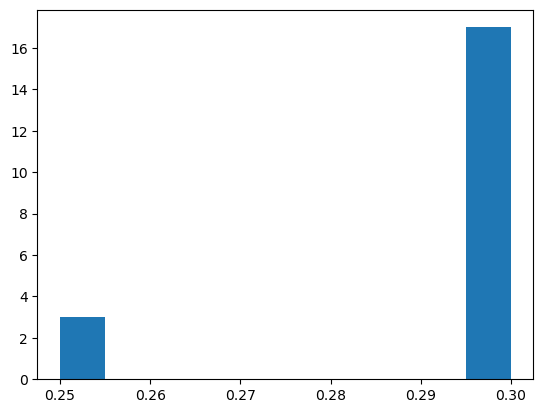

In [41]:
plt.hist(example_df['Match Prob'])

In [42]:
for _, row in example_df.sort_values('Match Prob').head().iterrows():
    print(textwrap.fill(row['Reason'], width=100))
    print()

The Reddit username 'andreNOLA' suggests someone named Andre from New Orleans, which matches the
first name and city of the profile. However, there is no last name, age, or other identifying
information in the snippet to confirm it is the same Andre Bennett born in 1972, so the probability
is low but not zero.

The Reddit username 'andreNOLA' suggests someone named Andre from New Orleans, which matches the
first name and city of the profile. However, there is no last name, age, or other identifying
information in the snippet to confirm it is specifically Andre Bennett born in 1972, so the
probability is low but not zero.

The Reddit username 'andreNOLA' suggests someone named Andre from New Orleans, which matches the
first name and city of the profile. However, there is no last name, age, or other identifying
information in the snippet to confirm it is the same Andre Bennett born in 1972, so the probability
is low but not zero.

The Reddit username 'andreNOLA' suggests someone named An

In [ ]:
# what further information or data points would you need to be more confident whether this is a match or not?

In [43]:
# no longer need to run multiple iterations because of temperature. write function to calculate from all models and print reasons

In [61]:
example_row = samples_df[samples_df['Is Match']] \
    .assign(diff=samples_df["Match Prob gpt-4.1"] - samples_df["Match Prob gpt-4.1-mini"]) \
    .sort_values("diff") \
    .drop(columns="diff") \
    .iloc[0]

result_dict = {}
for model in ALL_MODELS_LIST:
    result_dict[strip_trailing_date(model)] = get_match_prob(example_row, model, include_reason=True)

In [62]:
result_dict

{'gpt-4.1': (0.3,
  "The Reddit username 'andreNOLA' suggests someone named Andre from New Orleans, which matches the first name and city of the profile. However, there is no information about the last name, age, or other identifying details, so the probability of a match is low but not negligible."),
 'gpt-4.1-mini': (0.75,
  "The Reddit username 'andreNOLA' strongly suggests a connection to New Orleans, matching the city in the profile, and the first name Andre aligns; however, there is no direct evidence linking the Reddit user to the last name Bennett or birth year, so the match is probable but not certain."),
 'gpt-4.1-nano': (0.15,
  "The Reddit username 'u/andreNOLA' suggests a possible connection to New Orleans ('NOLA'), but there is no direct evidence linking this username to Andre Bennett, making the match unlikely but not impossible.")}